In [3]:
# Load the libraries to be used in the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_ta as ta
import seaborn as sns
import yfinance as yf
import requests
from io import StringIO

In [4]:
#Set the fiat currency pair
from_symbol = "USD"
to_symbol = "EUR"
interval = "60min"
api_key = "CV4O3KUIMS9TVCLR"

In [5]:
# Load the data from the API
url = f"https://www.alphavantage.co/query?function=FX_INTRADAY&from_symbol={from_symbol}&to_symbol={to_symbol}&interval={interval}&apikey={api_key}&datatype=csv"
request = requests.get(url)

In [29]:
#Convert the CSV to a pandas dataframe
data = StringIO(request.text)
csv_res_df = pd.read_csv(data)

In [30]:
# Convert to DataFrame
data_df = csv_res_df.copy()
data_df['timestamp'] = pd.to_datetime(data_df['timestamp'])
pricing_df = data_df.set_index('timestamp')
pricing_df.sort_index(ascending=True, inplace=True)

In [31]:
# Declare the variables that will be used globally as SMA window, Short Period and Long Period / Standard Deviation
# window : The SMA window
# length : The short period
# std : The long period

sma_window = 20
length = 10
std = 2

In [89]:
pricing_df.head()

,open,high,low,close,BBL_10_2.0,BBM_10_2.0,BBU_10_2.0,BBB_10_2.0,BBP_10_2.0
timestamp,,,,,,,,,
2023-09-29 07:00:00,0.9452,0.9452,0.9439,0.9439,NaN,NaN,NaN,NaN,NaN
2023-09-29 08:00:00,0.9440,0.9440,0.9423,0.9426,NaN,NaN,NaN,NaN,NaN
2023-09-29 09:00:00,0.9428,0.9432,0.9419,0.9422,NaN,NaN,NaN,NaN,NaN
2023-09-29 10:00:00,0.9424,0.9428,0.9417,0.9419,NaN,NaN,NaN,NaN,NaN
2023-09-29 11:00:00,0.9420,0.9425,0.9417,0.9422,NaN,NaN,NaN,NaN,NaN


In [101]:
pricing_df.ta.bbands(close = 'close', length = length, std= std, append = True)

#Create f strings for the column names
str_upper_band = f"BBU_{length}_{std}.0"
str_middle_band = f"BBM_{length}_{std}.0"
str_lower_band = f"BBL_{length}_{std}.0"

# Generate the trading signals
# 1 Represents a buy
# -1 represents a sell
# 0 represents a hold
buy_price = []
sell_price = []
bands_signal = []
signal = 0

for i in range(len(pricing_df['close'])):
    # Yesterday's price is above the lower band
    # Today's price is below the lower band
    # The price has dropped below the bands and a rise is expected
    if(pricing_df['close'][i-1] > pricing_df[str_lower_band][i-1] and pricing_df['close'][i] < pricing_df[str_lower_band][i]):

        # If we are not already in a buy position
        # Add today's price to the buy list
        # Update the signal to show we are in buy

        if(signal != 1):
            buy_price.append(pricing_df['close'][i])
            sell_price.append(np.nan)
            signal = 1
            bands_signal.append(signal)

        # We are in a buy position
        # Add nothing to every list

        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bands_signal.append(0)

    # Yesterday's price is below the upper band
    # Today's price is above the upper band
    # The price has increased above the bands and a drop is expected

    elif(pricing_df['close'][i-1] < pricing_df['close'][i-1] and pricing_df['close'][i] > pricing_df[str_upper_band][i]):

        # If we are not already in a sell position
        # Add today's price to the sell list
        # Update the signal to show we are in sell

        if(signal != -1):
            buy_price.append(np.nan)
            sell_price.append(pricing_df['close'][i])
            signal = -1
            bands_signal.append(signal)

        # We are in a sell position
        # Add nothing to every list

        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bands_signal.append(0)

    # Do nothing

    else:
        buy_price.append(np.nan)
        sell_price.append(np.nan)
        bands_signal.append(0)

#Create positions for our strategy
position = []
for i in range(len(bands_signal)):
    if bands_signal[i] > 1:
        position.append(0)
    else:
        position.append(1)

for i in range(len(pricing_df['close'])):
    # If we are in a buy position, set our position as buy
    if bands_signal[i] == 1:
        position[i] = 1
    # If we are in a sell position, set our position as sell
    elif bands_signal[i] == -1:
        position[i] = 0
    # Otherwise use yesterday's position
    else:
        position[i] = position[i-1]

In [105]:
#Create a copy of the main dataset
main_df_new = pricing_df.copy()

#Add the bands_signal list to the main dataset
main_df_new['Signal'] = bands_signal

#Add the positions list to the main dataset
main_df_new['Position'] = position

#Calculate Returns and Cummulative Returns and append to the DataFrame
#New column name is LOGRET_1
main_df_new.ta.log_return(close='close', append=True)

#New column name is CUMLOGRET_1
main_df_new.ta.log_return(close='close',cumulative=True, append=True)

main_df_new.head()

,open,high,low,close,BBL_10_2.0,BBM_10_2.0,BBU_10_2.0,BBB_10_2.0,BBP_10_2.0,Signal,Position,LOGRET_1,CUMLOGRET_1
timestamp,,,,,,,,,,,,,
2023-09-29 07:00:00,0.9452,0.9452,0.9439,0.9439,NaN,NaN,NaN,NaN,NaN,0,1,NaN,0.000000
2023-09-29 08:00:00,0.9440,0.9440,0.9423,0.9426,NaN,NaN,NaN,NaN,NaN,0,1,-0.001378,-0.001378
2023-09-29 09:00:00,0.9428,0.9432,0.9419,0.9422,NaN,NaN,NaN,NaN,NaN,0,1,-0.000424,-0.001803
2023-09-29 10:00:00,0.9424,0.9428,0.9417,0.9419,NaN,NaN,NaN,NaN,NaN,0,1,-0.000318,-0.002121
2023-09-29 11:00:00,0.9420,0.9425,0.9417,0.9422,NaN,NaN,NaN,NaN,NaN,0,1,0.000318,-0.001803


In [109]:
close_index = main_df_new.iloc[1]["CUMLOGRET_1"]
main_df_new['cum normal'] = (main_df_new["CUMLOGRET_1"]/close_index) * 100

main_df_new.head()

,open,high,low,close,BBL_10_2.0,BBM_10_2.0,BBU_10_2.0,BBB_10_2.0,BBP_10_2.0,Signal,Position,LOGRET_1,CUMLOGRET_1,cum normal
timestamp,,,,,,,,,,,,,,
2023-09-29 07:00:00,0.9452,0.9452,0.9439,0.9439,NaN,NaN,NaN,NaN,NaN,0,1,NaN,0.000000,-0.000000
2023-09-29 08:00:00,0.9440,0.9440,0.9423,0.9426,NaN,NaN,NaN,NaN,NaN,0,1,-0.001378,-0.001378,100.000000
2023-09-29 09:00:00,0.9428,0.9432,0.9419,0.9422,NaN,NaN,NaN,NaN,NaN,0,1,-0.000424,-0.001803,130.796979
2023-09-29 10:00:00,0.9424,0.9428,0.9417,0.9419,NaN,NaN,NaN,NaN,NaN,0,1,-0.000318,-0.002121,153.903294
2023-09-29 11:00:00,0.9420,0.9425,0.9417,0.9422,NaN,NaN,NaN,NaN,NaN,0,1,0.000318,-0.001803,130.796979


In [111]:
#Calculate the performance on the strategy data
main_df_new['Strategy'] = main_df_new['Position'].shift(1) * main_df_new['LOGRET_1']
main_df_new['Cummulative Strategy'] = main_df_new['Strategy'].cumsum().apply(np.exp)

In [112]:
stat_index = main_df_new.iloc[1]["Strategy"]
main_df_new['cum strat'] = (main_df_new["Strategy"]/stat_index) * 100

main_df_new.head()

,open,high,low,close,BBL_10_2.0,BBM_10_2.0,BBU_10_2.0,BBB_10_2.0,BBP_10_2.0,Signal,Position,LOGRET_1,CUMLOGRET_1,cum normal,Strategy,Cummulative Strategy,cum strat
timestamp,,,,,,,,,,,,,,,,,
2023-09-29 07:00:00,0.9452,0.9452,0.9439,0.9439,NaN,NaN,NaN,NaN,NaN,0,1,NaN,0.000000,-0.000000,NaN,NaN,NaN
2023-09-29 08:00:00,0.9440,0.9440,0.9423,0.9426,NaN,NaN,NaN,NaN,NaN,0,1,-0.001378,-0.001378,100.000000,-0.001378,0.998623,100.000000
2023-09-29 09:00:00,0.9428,0.9432,0.9419,0.9422,NaN,NaN,NaN,NaN,NaN,0,1,-0.000424,-0.001803,130.796979,-0.000424,0.998199,30.796979
2023-09-29 10:00:00,0.9424,0.9428,0.9417,0.9419,NaN,NaN,NaN,NaN,NaN,0,1,-0.000318,-0.002121,153.903294,-0.000318,0.997881,23.106315
2023-09-29 11:00:00,0.9420,0.9425,0.9417,0.9422,NaN,NaN,NaN,NaN,NaN,0,1,0.000318,-0.001803,130.796979,0.000318,0.998199,-23.106315


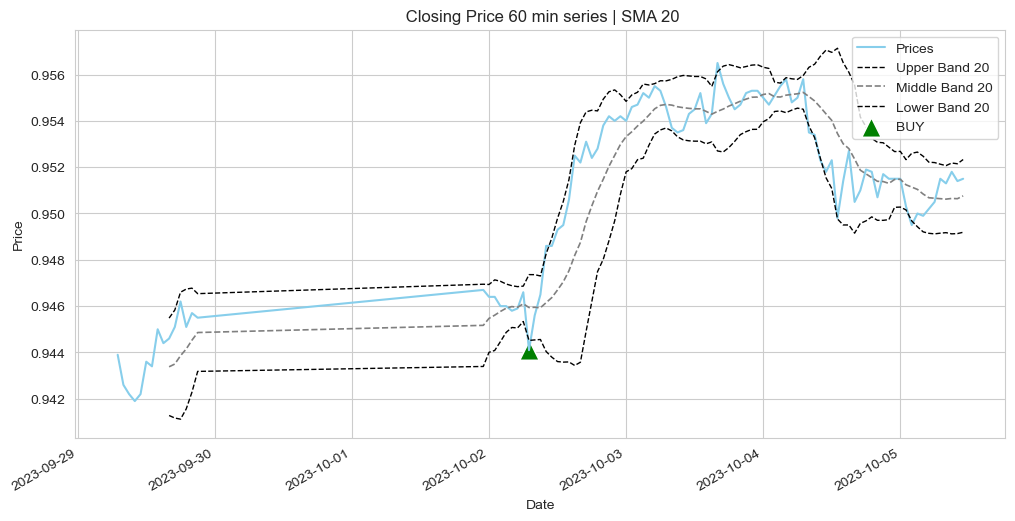

In [103]:
#Plot the figures with the trading signals
plt.figure(figsize = (12,6))
plt.title(" Closing Price 60 min series | SMA "+str(sma_window))
main_df_new['close'].plot(label = 'Prices', color = 'skyblue')
main_df_new[str_upper_band].plot(label = 'Upper Band '+str(sma_window), linestyle = '--', linewidth = 1, color = 'black')
main_df_new[str_middle_band].plot(label = 'Middle Band '+str(sma_window), linestyle = '--', linewidth = 1.2, color = 'grey')
main_df_new[str_lower_band].plot(label = 'Lower Band '+str(sma_window), linestyle = '--', linewidth = 1, color = 'black')
sns.scatterplot(x = main_df_new.index, y = sell_price, marker = 'v', color = 'red', label = 'SELL', s = 200)
sns.scatterplot(x = main_df_new.index, y = buy_price, marker='^', color = 'green', label = 'BUY', s = 200)
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(loc='upper right')
plt.show()

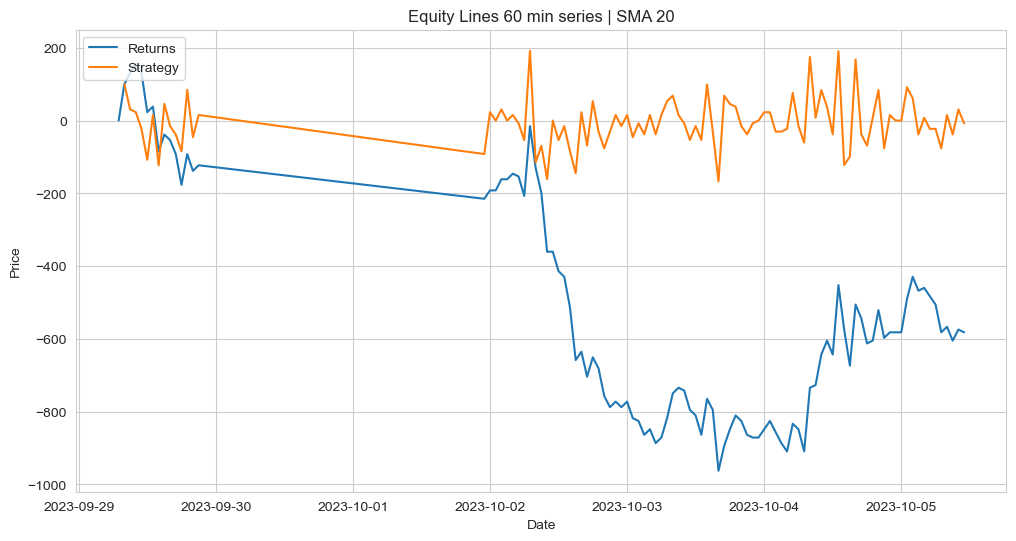

In [113]:
#Plot the figures with the trading signals
plt.figure(figsize = (12,6))
plt.title("Equity Lines 60 min series | SMA "+str(sma_window))
plt.plot(main_df_new['cum normal'], label = "Returns")
plt.plot(main_df_new['cum strat'], label = "Strategy")
plt.xlabel("Date")
plt.ylabel("Price")
sns.set_style("whitegrid")
plt.legend(loc='upper left')
plt.show()

In [28]:
main_df_new.tail()

,open,high,low,close,BBL_10_2.0,BBM_10_2.0,BBU_10_2.0,BBB_10_2.0,BBP_10_2.0,Signal,Position,LOGRET_1,CUMLOGRET_1,Strategy,Cummulative Strategy
timestamp,,,,,,,,,,,,,,,
2023-10-05 07:00:00,0.9502,0.9516,0.9502,0.9515,0.949151,0.95064,0.952129,0.313296,0.788753,0,1,0.001052,0.008019,0.001052,1.002871
2023-10-05 08:00:00,0.9514,0.9519,0.9508,0.9513,0.949173,0.95062,0.952067,0.304476,0.734936,0,1,-0.000210,0.007809,-0.000210,1.002661
2023-10-05 09:00:00,0.9514,0.9519,0.9505,0.9518,0.949121,0.95065,0.952179,0.321686,0.876050,0,1,0.000525,0.008335,0.000525,1.003188
2023-10-05 10:00:00,0.9517,0.9518,0.9507,0.9514,0.949132,0.95064,0.952148,0.317228,0.752015,0,1,-0.000420,0.007914,-0.000420,1.002766
2023-10-05 11:00:00,0.9515,0.9516,0.9513,0.9515,0.949190,0.95076,0.952330,0.330309,0.735635,0,1,0.000105,0.008019,0.000105,1.002871
